Hidden Markov Models (HMMs) are powerful, flexible methods for representing and classifying data with trends over time, and have been a key component in speech recognition systems for many years.

I found it very difficult to find a good example (with code) of a simple speech recognition system, so I decided to create this post. Though this implementation won't win any awards for "Best Speech Recognizer", I hope it will provide some insight into how HMMs can be used for speech recognition and other tasks.
<!-- TEASER_END -->

In this post, I will define what Hidden Markov Models are, show how to implement one form (Gaussian Mixture Model HMM, GMM-HMM) using numpy + scipy, and how to use this algorithm for single speaker speech recognition. For a more "production grade" HMM implementation, see [hmmlearn](https://github.com/hmmlearn/hmmlearn) which holds the HMM implementations that were formerly a part of [sklearn](http://scikit-learn.org/stable/).

Data
----

To demonstrate this algorithm, we need a dataset to operate on. I have chosen to use the sample dataset from [this Google Code project by Hakon Sandsmark](https://code.google.com/p/hmm-speech-recognition/downloads/list). I also used this code as a reference when creating my own implementation of a Guassian Mixture Model HMM (GMM-HMM). This aided in testing my implementation, as well as giving a frame of reference for performance. 

Other available datasets are largely multispeaker, but the simple frequency peak features used in this example do not work in the multispeaker regime (different speakers have different frequency content for the same word! Let alone male/female speech differences). Future work will cover more advanced feature extraction techniques for audio, and extend these examples to multispeaker recognition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
from utils import progress_bar_downloader

In [3]:
fpaths = []
labels = []
spoken = []
for f in os.listdir('audio'):
    for w in os.listdir('audio/' + f):
        fpaths.append('audio/' + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

Words spoken: ['lime', 'pineapple', 'kiwi', 'orange', 'apple', 'banana', 'peach']


This data has a total of 7 different spoken words, and each was spoken 15 different times, giving a grand total of 105 files. Next, the files will be extracted into a single data matrix (zero padding files to uniform length), and a label vector with the correct label for each data file is created.

In [4]:
#Files can be heard in Linux using the following commands from the command line
#cat kiwi07.wav | aplay -f S16_LE -t wav -r 8000
#Files are signed 16 bit raw, sample rate 8000
from scipy.io import wavfile

data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

Number of files total: 105
Labels and label indices [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6.]


Science Fiction (Double Feature)
--------------------------------

Once the data has been downloaded and turned into an input matrix, the next step is to extract features from the raw data, as is done in many other machine learning pipelines. 

Most "consumer grade" speaker recognition systems use advanced processing to extract a variety of features that describe the sound over both frequency and time, and until recently "custom features" were one of the keys to making a great recognition system. The current state of the art (to my knowledge, at least) has recently moved to using deep neural networks for feature extraction, which I hope to show in a future post. For now, we will stick to very simple features, in order to show a "simplest working example".

In this example MFCC is used

<Figure size 432x288 with 0 Axes>

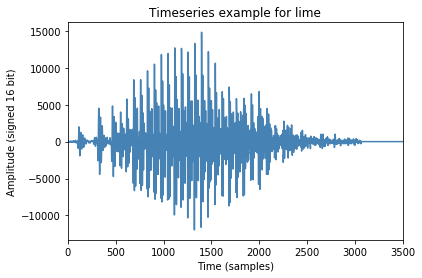

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
plt.plot(data[0, :], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()


GMM-HMM Bop
-----------

An implementation of a GMM-HMM is shown below. This code is also available as a [gist](https://gist.github.com/kastnerkyle/75483d51641a0c03bf7c), and any improvements I make will show up there.

This algorithm is fairly complex, and a good summary can be seen [here, Brown](http://cs.brown.edu/research/ai/dynamics/tutorial/Documents/HiddenMarkovModels.html) and [here, Moore](http://www.autonlab.org/tutorials/hmm.html). This implementation does *not* have any Viterbi backtracking - since my only interest (for now) is in speech classification, only Baum-Welch and Forward-Backward portions of the GMM-HMM are necessary.

HMMs can do do three primary tasks:

1. State Estimation $P(S | O)$ - can be useful *if* you have prior info about what states mean and create the state probabilities yourself.
2. Path Estimation - given observations, what is the most likely "state path"? Not useful in our case, and not even implemented here!
3. Maximum Likelihood Estimation $P(O | \lambda)$ - learn the HMM parameters $\lambda$ which maximize the probability of observations. This is the primary method we will use.

To train the HMM, we use the Baum-Welch algorithm. There are many, many resources on this algorithm and I will not regurgitate here. Implementing this HMM was fairly tricky, and I highly recommend using a library unless you are interested in a "learning experience".

This code uses requires scipy 0.14 for the multivariate_normal density.

Still Peaking
-------------

Once the mfcc are detected for each frame, we have a 3 dimensional numpy array of size [numdatafiles, numpeaks, numframes] 

To predict words, we need to train 7 separate GMM-HMM models, one for each word. We will then feed the features for a test sample into each, choosing the word associated with the GMM-HMM having the highest output likelihood. This maximum likelihood estimate is our best guess for what word was spoken.

We use the package from https://hmmlearn.readthedocs.io/en/latest/:<br>
**A fix to the package is described below!**

I analyzed the shape of the inner variables:<br>
msG[0].covars_prior =  [n_states, n_mix, n_features]<br>
msG[0].covars_weight = [n_states, n_mix, n_features]<br>
msG[0].means_prior =   [n_states, n_mix, n_features]<br>
msG[0].means_weight=   [n_states, n_mix]<br>
msG[0].weights_prior=  [n_states, n_mix]<br>
<br>
msG[0].transmat_ = [n_states, n_states]<br>
msG[0].startprob_= [n_states]<br>
msG[0].means__= [n_states, n_mix, n_features]<br>
msG[0].covars_= [n_states, n_mix, n_features] (this is for covariance_type == 'diag')<br>
msG[0].weights_ = [n_states, n_mix]<br>


When trying to utilize 'fit' of the hmm package we get an error that the sum of probabilities in the transfer matrix do not sum to one. After investigating the issue we see that the exponent of the log-probabilities is equal to inf. <br>
At stats.py line 41 there's the function _log_multivariate_normal_density_diag that calculates and return the too high log-probability. The calculation is: $-\frac{1}{2}(d\operatorname{log}(2\pi) + \sum_{i=1}^d \operatorname{log}(\sigma_i^2) + \sum_{i=1}^d\frac{\mu_i^2}{\sigma_i^2} - 2 X \cdot \mu \odot \sigma^2 + X^2 \cdot 1 \odot \sigma^2)$<br>
The problem seems to be because the $\sigma^2$ values are too small. <br>

The fix:
hmm.py @ line 985: self.covars_ = new_cov ---> self.covars_ = new_cov + self.min_covar<br>


# extracting MFCC features:

In [6]:
def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

In [7]:
import python_speech_features as mfcc
nWords = data.shape[0]
sr = 8000
features = list()
for wordIdx in range(nWords):
    mfcc_feat = mfcc.mfcc(signal=data[wordIdx], samplerate=sr, winlen=0.025, winstep=0.0025, numcep=20, appendEnergy=True)
    delta = calculate_delta(mfcc_feat)
    combined = np.hstack((mfcc_feat, delta))
    features.append(combined) # features is a list. each entry contains a matrix of MFCC coeffs for a specific wav file

In [8]:
nTrain = int(0.9*nWords)
nTest = nWords - nTrain

indexPermutation = np.random.permutation(nWords)
trainIdx = indexPermutation[:nTrain]
testIdx = indexPermutation[nTrain:]

trainWav = data[trainIdx, :]
testWav = data[testIdx, :]

trainLabels = all_labels[trainIdx]
testLabels = all_labels[testIdx]

    
testFeatures = np.asarray(())
testFeaturesLengths = np.asarray(())
for wordIdx in testIdx:    
    if testFeatures.size == 0:
        testFeatures = features[wordIdx]
        testFeaturesLengths = features[wordIdx].shape[0]
    else:
        testFeatures = np.vstack((testFeatures, features[wordIdx]))
        testFeaturesLengths = np.vstack((testFeaturesLengths, features[wordIdx].shape[0]))        

# Training on MFCC:

In [9]:
from hmmlearn.hmm import GMMHMM as GMMHMM

ys = set(all_labels)
covariance_type = 'diag'

msG = [GMMHMM(n_components=6, n_mix=1, n_iter=100, covariance_type=covariance_type, min_covar=1e-3) for y in ys] # ms[i] stores the gmmhmm model for word no. i i={0,...,6}
nModels = len(msG)
# my own long code for calling fit:
for modelIdx in range(nModels):
    
    trainFeatures = np.asarray(())
    trainFeaturesLengths = np.asarray(())
    
    for wordIdx in range(len(trainLabels)):
        wordLabel = trainLabels[wordIdx]        
        if wordLabel == modelIdx:
            if trainFeatures.size == 0:
                trainFeatures = features[trainIdx[wordIdx]]
                trainFeaturesLengths = int(features[trainIdx[wordIdx]].shape[0])
            else:
                trainFeatures = np.vstack((trainFeatures, features[trainIdx[wordIdx]]))
                trainFeaturesLengths = np.vstack((trainFeaturesLengths, int(features[trainIdx[wordIdx]].shape[0])))
    msG[modelIdx].fit(trainFeatures, trainFeaturesLengths.reshape(-1))

In [10]:
# test models:
nWavFilesInTest = len(testLabels)
res = np.zeros([nModels, nWavFilesInTest])
for modelIdx in range(nModels):
    for wavIdx in range(nWavFilesInTest):
        wavFeatures = features[testIdx[wavIdx]] #wavFeatures.shape: (n_samples, n_features)
        res[modelIdx, wavIdx] = msG[modelIdx].score(wavFeatures)
predicted_labels = np.argmax(res, axis=0) # the winnder-model for each wav-file
missed = (predicted_labels != testLabels)
print('hmm package Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

hmm package Test accuracy: 90.91 percent


Text(0.5, 0, 'Predicted label')

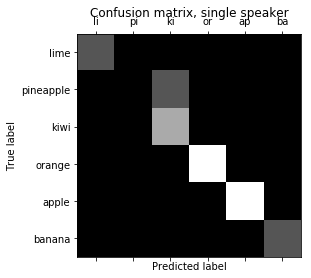

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testLabels, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Though the confusion matrix doesn't provide much insight, it is good to see a "real" example of using HMMs to do single speaker speech recognition.